In [11]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate
import Utils
from Utils import Constants
import cv2
from facenet_pytorch import InceptionResnetV1
from Models import *
from DataLoaders import *
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score,confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def get_model(file):
    model = torch.load(Constants.model_folder + file).to(torch.device('cpu'))
    model.load_state_dict(torch.load(Constants.model_folder + file + '_states'))
    model.eval()
    return model

def eval_labels(model,labels,use_histogram=False,filter_nonfaces=False,**kwargs):
    device = torch.device('cpu')
    names = Constants.labels[:]
    model = model.to(device)
    if filter_nonfaces:
        labels = labels[labels.is_face]
    dataset = FaceGenerator(labels,Constants.data_root,upsample=False,validation=True,shuffle_on_init=False,random_upsample=False,filter_nonfaces=filter_nonfaces,**kwargs)
    print(labels.shape[0],len(dataset))
    predicted = [[],[],[]]
    actual = [[],[],[]]
    with torch.no_grad():
        for i,[xbatch, ybatch] in enumerate(dataset):
            if use_histogram:
                xb = add_batch_histogram(xbatch,device=device,grad=False)
            else:
                xb = xbatch.to(device)
            ypreds = model(xb)
            for ii,(ytrue,ypred) in enumerate(zip(ybatch,ypreds)):
                predicted[ii].append(ypred.detach().numpy())
                actual[ii].append(ytrue.detach().numpy())
    for i in range(len(predicted)):
        predicted[i] = np.concatenate(predicted[i],axis=0)
        actual[i] = np.concatenate(actual[i],axis=0)
    return actual, predicted

def subclass_predictions(ytrue,ypred):
    yt = np.stack(ytrue,axis=-1).T
    yp = np.stack([np.argmax(yyp,axis=-1) for yyp in ypred])
    yp_prob = np.stack([np.amax(yyp,axis=-1) for yyp in ypred])
    groupstring = lambda x: '-'.join([str(i) for i in x])
    group_p = np.apply_along_axis(groupstring, 0, yp)
    group_t = np.apply_along_axis(groupstring, 0, yt)
    return group_t, group_p, yp_prob

def subgroup_results(y,predicted):
    entry = {
        'accuracy': accuracy_score(y,predicted),
        'f1': f1_score(y,predicted),
        'precision': precision_score(y,predicted,zero_division=0),
        'recall': recall_score(y,predicted),
    }
    return entry
    
def multiclass_metrics(y,ypred,labels=None):
    squeeze = lambda yy: np.argmax(yy,axis=1) if yy.ndim > 1 else yy
    res = {}
    if labels is None:
        labels = Constants.labels[:]
    for yy, yypred, label in zip(y,ypred,labels):
        yypred = squeeze(yypred)
        entry = {
            'accuracy': accuracy_score(yy,yypred),
#             'f1_micro': f1_score(yy,yypred,average='micro'),
            'f1': f1_score(yy,yypred,average='macro'),
            'precision': precision_score(yy,yypred,average='macro'),
            'recall': balanced_accuracy_score(yy,yypred),
        }
        res[label] = entry
    return pd.DataFrame(res)

def get_classwise_metrics(ylist,ypredlist):
    labels = Constants.labels[:]
    results = {}
    ygroup, ygroup_pred,_ = subclass_predictions(ylist,ypredlist)
    ylist = ylist + [ygroup]
    ypredlist = ypredlist + [ygroup_pred]
    labels = labels + ['subgroup']
    getmax = lambda res,key: np.max([v[key] for k,v in res.items() if key != 'multiclass'])
    getmin = lambda res,key: np.min([v[key] for k,v in res.items() if key != 'multiclass'])
    global_results = multiclass_metrics(ylist,ypredlist,labels)
    for i, name in enumerate(labels):
        y = ylist[i]
        ypred = ypredlist[i]
        classes = np.unique(y)
        class_entry = {}
        for c in classes:
            yset = (y == c).astype(int)
            if ypred.ndim > 1:
                yp = (np.argmax(ypred,axis=1) == c).astype(int)
            else:
                yp = (ypred == c).astype(int)
            vals = subgroup_results(yset,yp)
            class_entry[c] = vals
        extents = {}
        for key in class_entry[classes[0]].keys():
            maxval = getmax(class_entry,key)
            minval = getmin(class_entry,key)
            extents[key] = maxval - minval
        class_entry['differential'] = extents
        class_entry['multiclass'] = global_results.get(name,{'accuracy':0,'f1':0,'precision':0,'recall':0})
        results[name] = pd.DataFrame(class_entry)
    return results

def plot_confusion_matrices(y,ypred):
    ygroup, ygroup_pred ,_ = subclass_predictions(y,ypred)
    y = y + [ygroup]
    ypred = ypred + [ygroup_pred]
    
    fig, axes = plt.subplots(len(y),1,
                             figsize=(10,45),
                             gridspec_kw = {'height_ratios':[1,1,1,3]}
                            )
    titles = Constants.labels[:] + ['subgroup']
    cms = []
    for i in range(len(y)):
        if ypred[i].ndim > 1:
            yp = np.argmax(ypred[i],axis=1)
        else:
            yp = ypred[i]
        sublabels = sorted(set(np.unique(y[i])).union(set(np.unique(yp))))
        cm = confusion_matrix(y[i],yp,labels=sublabels)
        Utils.ConfusionMatrixDisplay.from_predictions(y[i],ypred[i],
                                                      ax=axes[i],
                                                      normalize='true',
                                                      colorbar=False,
                                                      display_labels=sublabels,
                                                      include_values = (i < 3),
                                                      title=titles[i])
        cms.append(cm)
    return

def plot_results(results):
    fig, axes = plt.subplots(4,1,
                             figsize=(10,40),
                             gridspec_kw = {'height_ratios':[5,2,1,35]}
                            )
    for i,(k,v) in enumerate(results.items()):
        a = sns.heatmap(
            v.T,
            ax=axes[i],
            cmap='Greens',
            annot=True,
            vmin=0,
            vmax=1,
            cbar=False,
        )
        a.xaxis.tick_top()
        a.set_title(k)
    return

def resultify(y,ypred):
    res = get_classwise_metrics(y,ypred)
    plot_confusion_matrices(y,ypred)
    plot_results(res)
    return res


In [13]:
train_labels = pd.read_csv('train_data_clean.csv')
val_labels = pd.read_csv('validation_data_clean.csv')
test_labels = pd.read_csv('test_data_clean.csv')
test_labels.shape, train_labels.shape, val_labels.shape

((3000, 5), (6842, 5), (1711, 5))

In [14]:
#code for getting results

In [15]:
#dualfacenet + histogram
# file = 'dual_dualfacenet_h400_st600_a400_g400_ed3_std2_ad2_gd2_hist10_histd_0.1_balanced'

# #dual facenet
# file = 'dual_dualfacenet_h1000_st600_a400_g400_ed4_std2_ad2_gd2'

#triplet model
# file='abstractmodeltriplet_decoder__st600_a400_g400_std2_ad2_gd2_balanced'

# file = 'abstractmodeltriplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced'

# file = 'dualencoder_resnetbase_h400_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced'
# file = 'gridsearch_mediumdualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a100_g100_std2_ad2_gd2_rbalanced_lw2-1-1_noise01'
# file = 'gridsearch_smalldualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedsoft_lw1-1-1_noise1'
file = 'gridsearch3_smalldualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedsoftembed9.0_lw2-1-2_noise01_smote0.5_flprot0.7-0.1_V0.8197'

In [ ]:
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)


def calc_scores(y,ypred):
    ypred = [np.argmax(yy,axis=1) for yy in ypred]
    acc ={}
    disp = {}
    for yy, yp, name in zip(y,ypred,Constants.labels[:]):
        acc[name] = accuracy_score(yy,yp)
        disp[name] = disparity_score(yy,yp)
    return {'accuracy': acc,'disparity': disp}

def score_func(acc, disp, csize):
    return csize * acc * (1-disp**(csize/2))

def get_score(y,ypred):
    results = calc_scores(y,ypred)
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    
    res = {
        'submission_name': 'placeholder',
        'score': ad,
        'metrics': results
    }
    return res

def model_score(file,labels,use_histogram=False,get_metrics = False):
    model = get_model(file)
    y,ypred = eval_labels(model, labels,use_histogram=use_histogram)
    res = get_score(y,ypred)
    return res,y,ypred

res, y, ypred = model_score(file,test_labels)
pd.DataFrame(res['metrics']).plot(kind='barh')
res

(3000, 5)
3000 30


/opt/conda/envs/rapids/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
def model_results(filelist,labels):
    reslist = {}
    for file in filelist:
        res, _, __ = model_score(file,labels)
        reslist[file] = res
    return reslist

def get_search_results(name='_smote_gridsearch.csv'):
    res = pd.read_csv(Constants.result_folder + name).sort_values('score',ascending=False).drop('Unnamed: 0',axis=1)
    return res

def get_top_models(name, k = 100, min_score = 7):
    res = get_search_results(name=name)
    res = res[res.score >= min_score]
    if res.shape[0] > k:
        res = res.iloc[0:k]
    return res.model.values.tolist()

compare_files = get_top_models('_smote_gridsearch.csv',k=200,min_score = 4)
compare_res = model_results(compare_files,test_labels)

(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30
(3000, 5)
3000 30


In [97]:
compare_res

{'../../data/models/gridsearch3_smalldualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedsoftembed9.0_lw2-1-2_noise01_smote0.5_flprot0.7-0.1_V0.8197': {'submission_name': 'placeholder',
  'score': 6.760959975426541,
  'metrics': {'accuracy': {'skin_tone': 0.299,
    'age': 0.6583333333333333,
    'gender': 0.8536666666666667},
   'disparity': {'skin_tone': 0.4660831509846827,
    'age': 0.41234984668185776,
    'gender': 0.032911392405063356}}},
 '../../data/models/gridsearch3_smalldualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedsoftembed9.0_lw2-1-2_noise01_flprot0.7-0.1_V0.4348': {'submission_name': 'placeholder',
  'score': 6.871217263657538,
  'metrics': {'accuracy': {'skin_tone': 0.3,
    'age': 0.6646666666666666,
    'gender': 0.8456666666666667},
   'disparity': {'skin_tone': 0.42935779816513764,
    'age': 0.37712171213563306,
    'gender': 0.03363671234787469}}},
 '../../data/models/gridsearch3_smalldualenco

In [95]:
import re
def get_smote(string):
    pat = re.compile('smote([0-9]*[.]*[0-9]*)_')
    vals = pat.findall(string)
    if len(vals) < 1:
        return 0
    return float(vals[0])

def score_func(acc, disp, csize):
    return csize * acc * (1-disp**(csize/2))

def row_score(row,label):
    acc = row[label + '_accuracy']
    disp = row[label + '_disparity']
    csize = 10
    if label == 'gender':
        csize = 2
    elif label == 'age':
        csize = 4
    return score_func(acc,disp,csize)

def unravel_metrics(df):
    for metric_col in ['accuracy','f1','disparity']:
        for i,label in enumerate(Constants.labels):
            df[label+'_'+metric_col] = df[metric_col].apply(lambda x: float(x.replace(']','').replace('[','').split(',')[i]))
        df = df.drop(metric_col,axis=1)
    for label in Constants.labels:
        df[label+'_score'] = df.apply(lambda r: row_score(r,label),axis=1)
    return df

smote_df = get_search_results(name='_smote_gridsearch.csv')
smote_df['dual'] = smote_df.model.apply(lambda x: 'simpledualencoder' in x)
smote_df['smote'] = smote_df.model.apply(lambda x: get_smote(x))
smote_df = smote_df.sort_values('score',ascending=False).groupby(['dual','softmax','noise','embed_weight','smote']).first()
smote_df = unravel_metrics(smote_df)
smote_df = smote_df.drop(['weight_type','loss_weights'],axis=1)
smote_df['test_score'] = com
smote_df.drop(['model','loss'],axis=1)

score  skin_tone_accuracy  \
dual  softmax noise embed_weight smote                                 
False False   0.01  0.0          0.0    7.542976            0.349422   
                                 0.5    7.566871            0.326489   
                                 0.9    7.367869            0.335733   
                    0.1          0.0    7.597733            0.334578   
                                 0.5    7.598583            0.347733   
                                 0.9    7.598286            0.353778   
                    0.9          0.0    7.581640            0.352533   
                                 0.5    7.780896            0.349333   
                                 0.9    7.231303            0.355378   
      True    0.01  0.0          0.0    6.237326            0.338133   
                                 0.5    7.048586            0.317244   
                                 0.9    7.485655            0.338489   
                    0.1          0.0    7.652904            0.340889   
                                 0.5    7.545885            0.336533   
                                 0.9    7.571199            0.351733   
                    0.9          0.0    7.791536            0.367733   
                                 0.5    7.835547            0.357867   
                                 0.9    7.584182            0.347822   
True  False   0.01  0.0          0.0    6.006757            0.333867   
                                 0.5    6.261657            0.340533   
                                 0.9    6.401409            0.349067   
                    0.1          0.0    6.289895            0.346933   
                                 0.5    6.211707            0.335378   
                                 0.9    7.512290            0.312889   
                    0.9          0.0    6.141765            0.349422   
                                 0.5    7.662343            0.338133   
                                 0.9    7.649905            0.354222   
      True    0.01  0.0          0.0    5.766613            0.319289   
                                 0.5    6.338873            0.344622   
                                 0.9    6.154104            0.328889   
                    0.1          0.0    6.251948            0.344622   
                                 0.5    7.588341            0.332978   
                                 0.9    7.589274            0.332533   
                    0.9          0.0    7.610636            0.357689   
                                 0.5    6.320372            0.350222   
                                 0.9    6.266818            0.338133   

                                        age_accuracy  gender_accuracy  \
dual  softmax noise embed_weight smote                                  
False False   0.01  0.0          0.0        0.689867         0.909600   
                                 0.5        0.719556         0.916800   
                                 0.9        0.699911         0.924800   
                    0.1          0.0        0.711111         0.926400   
                                 0.5        0.698400         0.909956   
                                 0.9        0.698311         0.916000   
                    0.9          0.0        0.701156         0.904800   
                                 0.5        0.708711         0.900800   
                                 0.9        0.714311         0.907556   
      True    0.01  0.0          0.0        0.666578         0.909600   
                                 0.5        0.685511         0.898756   
                                 0.9        0.703111         0.903556   
                    0.1          0.0        0.698667         0.913156   
                                 0.5        0.703467         0.916800   
                                 0.9        0.732800         0.911556   
                    0.9          0.0        0.703111         0.90

In [343]:
smote_df.to_csv('test.csv')

<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

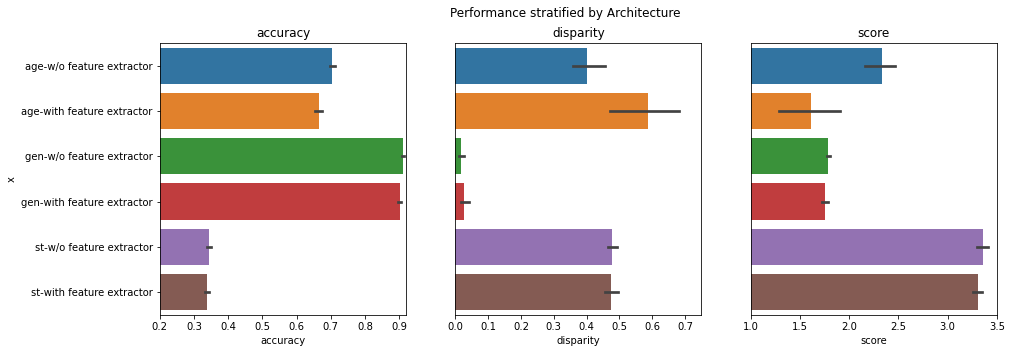

In [259]:
import seaborn as sns

def plot_metric(smote_df,by = 'dual', name_func=lambda x: str(x),title=None, alim = [.2,.92],dlim=[0,.75],slim=[1,3.5]):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    smotedf = smote_df.drop(['model','loss'],axis=1).reset_index().sort_values('score')
    score_cols = []
    metrics =  ['accuracy','disparity','score']
    tempdf = []
    for i, row in smotedf.iterrows():
        for label in Constants.labels:
            entry = {
                by: row[by],
                'task': label,
            }
            for metric in metrics:
                entry[metric] = row[label + '_' + metric]
            tempdf.append(entry)
    tempdf = pd.DataFrame(tempdf)
    for ax, metric in zip(axes, metrics):
        temp = tempdf.copy().sort_values(by,kind='mergesort').sort_values('task',kind='mergesort')
        temp['x'] = temp.task.apply(lambda x: 'st' if x == 'skin_tone' else x[0:3]) + temp[by].apply(lambda x: '-' + name_func(x))
        g = sns.barplot(
            data=temp,
            y = 'x',
            x = metric,
            ax=ax,
            orient='h'
        )
        ax.set_title(metric)
        if metric != 'accuracy':
            ax.get_yaxis().set_visible(False)
        if metric == 'accuracy':
            ax.set_xlim(alim[0],alim[1])
        elif metric == 'disparity':
            ax.set_xlim(dlim[0],dlim[1])
        else:
            ax.set_xlim(slim[0],slim[1])
    if title is None:
        title=by
    fig.suptitle("Performance stratified by" + ' ' + title)
    return ax

plot_metric(smote_df,name_func = lambda x: 'with feature extractor' if x else 'w/o feature extractor', title='Architecture')

<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

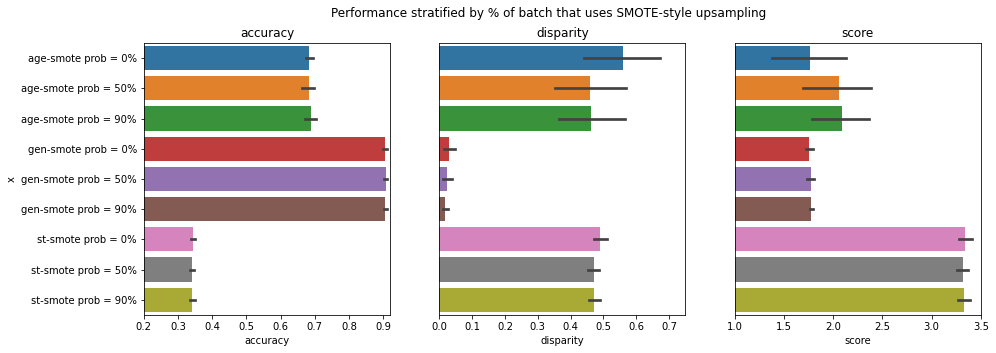

In [206]:
plot_metric(smote_df,'smote',name_func = lambda x: 'smote prob = ' + str(int(100*x)) + '%',title ='% of batch that uses SMOTE-style upsampling')


<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

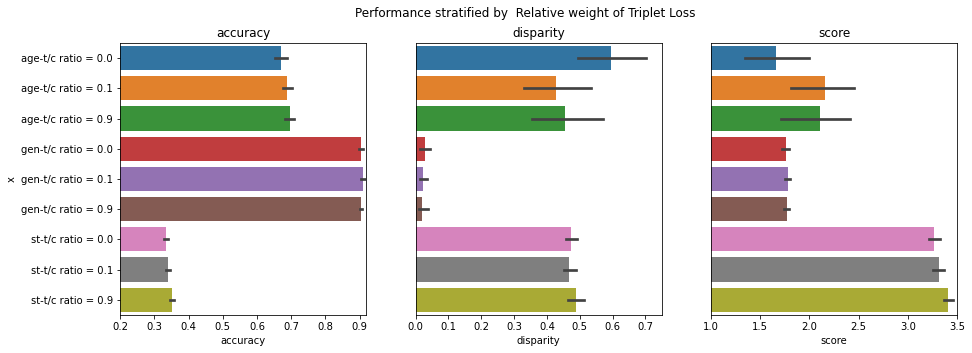

In [207]:
plot_metric(smote_df,'embed_weight',name_func = lambda x: 't/c ratio = ' + str(x), title = ' Relative weight of Triplet Loss')


<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

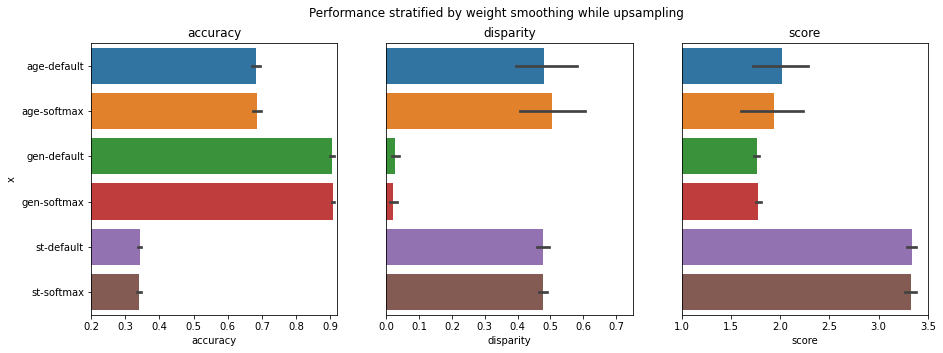

In [208]:
plot_metric(smote_df,'softmax',name_func = lambda x: 'softmax' if x else 'default', title = 'weight smoothing while upsampling')

In [334]:
# smote_test_scores = model_results(smote_df.model.values.tolist(),test_labels)
smote_test_scores

{'../../data/models/gridsearch3_smalldualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedembed0.0_lw2-1-2_noise01_flprot0.7-0.1_V0.9764': {'submission_name': 'placeholder',
  'score': 6.793533567701396,
  'metrics': {'accuracy': {'skin_tone': 0.2843333333333333,
    'age': 0.665,
    'gender': 0.8383333333333334},
   'disparity': {'skin_tone': 0.4342105263157895,
    'age': 0.3355444903930008,
    'gender': 0.025700038358266175}}},
 '../../data/models/gridsearch3_smalldualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedembed0.0_lw2-1-2_noise01_smote0.5_flprot0.7-0.1_V0.1842': {'submission_name': 'placeholder',
  'score': 6.5993751518365205,
  'metrics': {'accuracy': {'skin_tone': 0.279,
    'age': 0.6703333333333333,
    'gender': 0.8453333333333334},
   'disparity': {'skin_tone': 0.3995381062355658,
    'age': 0.41286747123526596,
    'gender': 0.04563936255535794}}},
 '../../data/models/gridsearch3_smalldualencoder_dua

In [220]:
# alt_df = pd.read_csv(Constants.result_folder + '_alt_gridsearch.csv').drop('Unnamed: 0')
# alt_df

In [268]:
def g2_model_name(model):
    string = model.replace('../../data/models/','')
    string = string.replace('gridsearch','').replace('gridsearc','')
    string = re.sub('h[0-9]*_','',string)
    string = re.sub('_noise[0-9]*','',string)
    string = re.sub('__st[0-9]*_a[0-9]*_g[0-9]*_std[0-9]*_ad[0-9]*_gd[0-9]*_[a-z_]*lw','',string)
    string = re.sub('[0-9]-[0-9]-[0-9]','',string)
    string = string.replace('ed3','')
    return string
griddf = pd.read_csv(Constants.result_folder + 'gridsearch2.csv')
print(griddf.model.unique())
griddf['mname'] = griddf.model.apply(g2_model_name)
griddf = griddf.drop(['Unnamed: 0'],axis=1)
griddf = unravel_metrics(griddf)
griddf
# griddf = griddf.sort_values('score',ascending=False).groupby('mname').first().reset_index()

['../../data/models/dualencoder_dualfacenet_h400_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_lw5-2-1_noise0'
 '../../data/models/dualencoder_gridsearch_resnet_h400_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_lw5-2-1_noise0'
 '../../data/models/dualencoder_dualfacenet_h500_h500_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_lw5-2-1_noise0'
 '../../data/models/frozen_dualencoder_gridsearch_frozen_h400_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_lw5-2-1_noise0'
 '../../data/models/dualencoder_dualfacenet_h400_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_lw5-2-1_noise05'
 '../../data/models/dualencoder_gridsearch_resnet_h400_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_lw5-2-1_noise05'
 '../../data/models/dualencoder_dualfacenet_h500_h500_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_lw5-2-1_noise05'
 '../../data/models/frozen_dualencoder_gridsearch_frozen_h400_ed3triplet_decoder__st600_a400_g

,score,loss,noise,softmax,embed_weight,model,loss_weights,mname,skin_tone_accuracy,age_accuracy,gender_accuracy,skin_tone_f1,age_f1,gender_f1,skin_tone_disparity,age_disparity,gender_disparity,skin_tone_score,age_score,gender_score
0,5.915858,13.063556,0.0,False,0.9,../../data/models/dualencoder_dualfacenet_h400...,"[5, 2, 1]",dualencoder_dualfacenet_triplet_decoder,0.346133,0.688267,0.906400,0.185102,0.332796,0.450744,0.466000,0.850476,0.024249,3.385270,0.761746,1.768842
1,5.537529,13.417130,0.0,False,0.9,../../data/models/dualencoder_gridsearch_resne...,"[5, 2, 1]",dualencoder__resnet_triplet_decoder,0.298044,0.628178,0.875200,0.155802,0.299373,0.435887,0.494289,0.781715,0.047202,2.892504,0.977247,1.667777
2,5.622331,13.344961,0.0,False,0.9,../../data/models/dualencoder_dualfacenet_h500...,"[5, 2, 1]",dualencoder_dualfacenet_triplet_decoder,0.318933,0.671200,0.889956,0.172806,0.313983,0.442486,0.468999,0.852326,0.005027,3.116963,0.734403,1.770964
3,5.166327,13.616287,0.0,False,0.9,../../data/models/frozen_dualencoder_gridsearc...,"[5, 2, 1]",frozen_dualencoder__frozen_triplet_decoder,0.270400,0.613778,0.795467,0.139677,0.288912,0.391976,0.437848,0.774715,0.041916,2.660487,0.981594,1.524247
4,5.828672,13.153658,0.0,False,0.9,../../data/models/dualencoder_dualfacenet_h500...,"[5, 2, 1]",dualencoder_dualfacenet_triplet_decoder,0.337778,0.662578,0.902400,0.179694,0.318722,0.449044,0.450618,0.854862,0.002570,3.315019,0.713492,1.800161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,5.525425,13.367973,0.5,False,0.1,../../data/models/dualencoder_dualfacenet_h400...,"[5, 2, 1]",dualencoder_dualfacenet_triplet_decoder,0.323733,0.644622,0.865956,0.172909,0.306707,0.430230,0.620714,0.815587,0.005108,2.939038,0.863323,1.723064
71,5.586019,13.399657,0.5,False,0.1,../../data/models/dualencoder_gridsearch_resne...,"[5, 2, 1]",dualencoder__resnet_triplet_decoder,0.308089,0.632978,0.858222,0.166168,0.303106,0.425996,0.493690,0.785877,0.051942,2.990535,0.968195,1.627289
72,5.473866,13.259224,0.5,False,0.1,../../data/models/dualencoder_dualfacenet_h500...,"[5, 2, 1]",dualencoder_dualfacenet_triplet_decoder,0.320089,0.668356,0.864800,0.165452,0.312619,0.428876,0.471628,0.867531,0.025039,3.126198,0.661377,1.686292
73,4.449845,13.910833,0.5,False,0.1,../../data/models/frozen_dualencoder_gridsearc...,"[5, 2, 1]",frozen_dualencoder__frozen_triplet_decoder,0.232533,0.579378,0.756267,0.121884,0.251495,0.373241,0.407117,0.823031,0.072521,2.299327,0.747675,1.402843


<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

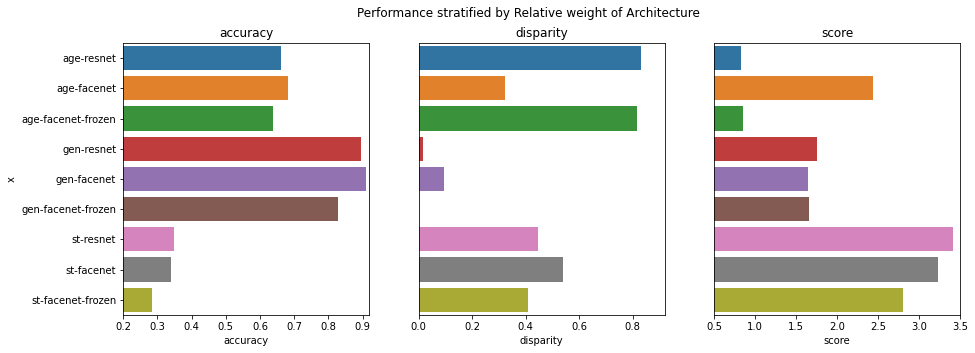

In [272]:
plot_metric(griddf.sort_values('score',ascending=False).groupby('mname').first().reset_index(),
            'mname',
            name_func = lambda x: x.replace('dualencoder_','').replace('triplet_decoder','').replace('_','').replace('dual','').replace('frozenfrozen','facenet-frozen'), 
            title = 'Relative weight of Architecture',
            alim = [.2,.92],
            dlim=[0,.92],
            slim=[.5,3.5]
           )

In [333]:
def stg_model_name(model):
    string = model.replace('../../data/models/','')
    string = string.replace('gridsearch','').replace('gridsearc','')
    string = re.sub('h[0-9]*_','',string)
    string = re.sub('_noise[0-9]*','',string)
    string = re.sub('_st[0-9]*_a[0-9]*_g[0-9]*_std[0-9]*_ad[0-9]*_gd[0-9]*','',string)
    string = re.sub('[0-9]-[0-9]-[0-9]','',string)
    string = re.sub('spab[0-9]*','',string)
    string = string.replace('rbalanced__lw.5','').replace('ed3triplet_decoder__','')
    string= string.replace('_','').replace('dualencoder','')
    string = string.replace('frozenfrozen','frozen').replace('baseline','')
    string =string.replace('model','')
    if 'simple' in string:
        return 'simple'
    return string

grid2 = pd.read_csv(Constants.result_folder + '_st_gridsearch.csv')
grid2['mname'] = grid2.model.apply(stg_model_name)
grid2 = grid2.drop(['Unnamed: 0'],axis=1)
grid2 = unravel_metrics(grid2)
grid2.sort_values('score',ascending=False)

,score,loss,noise,softmax,embed_weight,model,st_patch_prob,mname,skin_tone_accuracy,age_accuracy,gender_accuracy,skin_tone_f1,age_f1,gender_f1,skin_tone_disparity,age_disparity,gender_disparity,skin_tone_score,age_score,gender_score
36,6.269507,5.433203,0.01,True,0.5,../../data/models/gridsearch_baselinedualencod...,0.01,dualfacenet,0.365689,0.689067,0.917600,0.191791,0.334806,0.456834,0.525192,0.810839,0.011223,3.510771,0.944133,1.814603
0,6.179521,5.485950,0.01,False,0.5,../../data/models/gridsearch_baselinedualencod...,0.01,dualfacenet,0.336622,0.692267,0.901956,0.178511,0.342278,0.448735,0.461429,0.774567,0.015494,3.295807,1.107752,1.775962
37,6.111635,5.529935,0.01,True,0.5,../../data/models/gridsearch_resnetdualencoder...,0.01,resnet,0.336533,0.655022,0.880356,0.175091,0.318605,0.437821,0.420985,0.769484,0.021939,3.320833,1.068719,1.722083
4,6.084449,5.481202,0.10,False,0.5,../../data/models/gridsearch_baselinedualencod...,0.01,dualfacenet,0.348533,0.681511,0.892356,0.187445,0.332887,0.443309,0.527162,0.797146,0.021014,3.343440,0.993801,1.747208
25,6.056513,5.559033,0.01,False,0.5,../../data/models/gridsearch_resnetdualencoder...,0.20,resnet,0.333778,0.630578,0.877511,0.178506,0.303840,0.436018,0.493700,0.737140,0.051361,3.239880,1.151750,1.664883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,4.690981,5.793136,0.25,False,0.5,../../data/models/gridsearch_frozenfrozen_dual...,0.01,frozen,0.236889,0.619911,0.771556,0.121270,0.292747,0.381803,0.426594,0.793601,0.068376,2.335422,0.917960,1.437600
59,4.586909,5.845233,0.25,True,0.5,../../data/models/gridsearch_frozenfrozen_dual...,0.10,frozen,0.216089,0.586933,0.753333,0.109593,0.266888,0.372479,0.397796,0.756482,0.042033,2.139364,1.004208,1.443338
23,4.563948,5.824622,0.25,False,0.5,../../data/models/gridsearch_frozenfrozen_dual...,0.10,frozen,0.231289,0.599822,0.749333,0.111933,0.273453,0.371142,0.449587,0.810564,0.018713,2.270405,0.822921,1.470623
47,4.483065,5.816178,0.25,True,0.5,../../data/models/gridsearch_frozenfrozen_dual...,0.01,frozen,0.240533,0.587467,0.759111,0.133413,0.261071,0.374314,0.483681,0.827382,0.077758,2.341658,0.741239,1.400168


<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

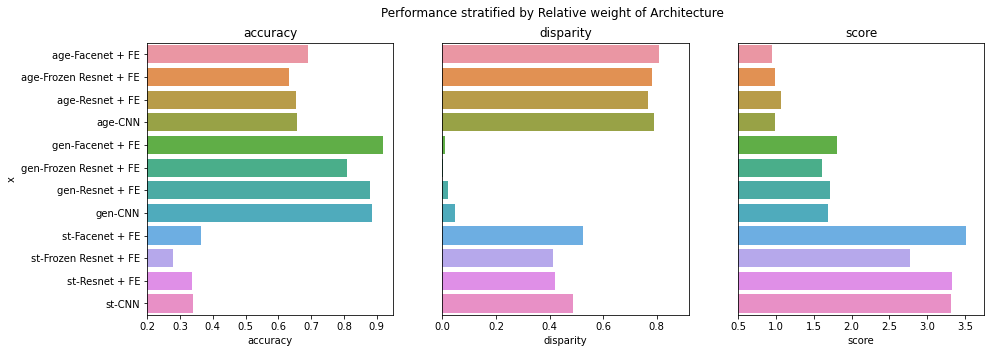

In [325]:
temp = {
    'dualfacenet': 'Facenet + FE',
    'frozen': 'Frozen Resnet + FE',
    'resnet': 'Resnet + FE',
    'simple': 'CNN',
}
plot_metric(grid2.sort_values('score',ascending=False).groupby('mname').first().reset_index(),
            'mname',
            title = 'Relative weight of Architecture',
            name_func = lambda x: temp.get(x,x),
            alim = [.2,.95],
            dlim=[0,.92],
            slim=[.5,3.75]
           )

<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

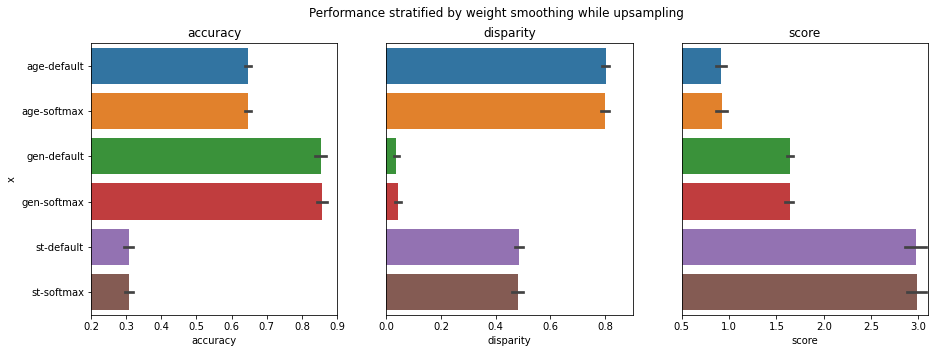

In [315]:
plot_metric(grid2.sort_values('score',ascending=False),
            'softmax',
            name_func = lambda x: 'softmax' if x else 'default', 
            title = 'weight smoothing while upsampling',
            alim = [.2,.9],
            dlim=[0,.9],
            slim=[.5,3.1]
           )

<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

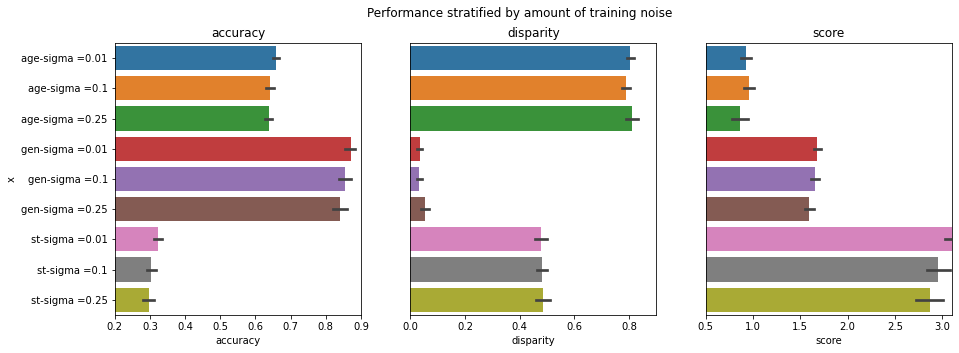

In [320]:
plot_metric(grid2.sort_values('score',ascending=False,kind='mergesort').sort_values('noise',kind='mergesort'),
            'noise',
            name_func = lambda x: 'sigma =' + str(x), 
            title = 'amount of training noise',
            alim = [.2,.9],
            dlim=[0,.9],
            slim=[.5,3.1]
           )

<AxesSubplot:title={'center':'score'}, xlabel='score', ylabel='x'>

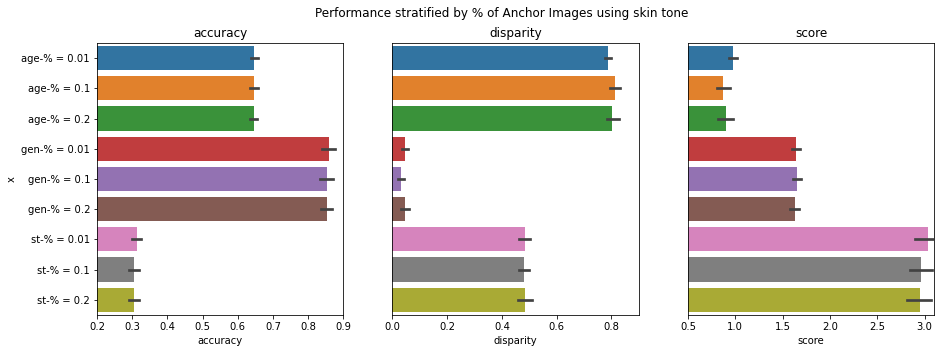

In [323]:
plot_metric(grid2.sort_values('score',ascending=False,kind='mergesort').sort_values('st_patch_prob',kind='mergesort'),
            'st_patch_prob',
            name_func = lambda x: '% = ' + str(x), 
            title = '% of Anchor Images using skin tone',
            alim = [.2,.9],
            dlim=[0,.9],
            slim=[.5,3.1]
           )

,score,loss,noise,embed_weight,model,softmax,weight_type,loss_weights,rotate_prob,skin_tone_accuracy,...,skin_tone_f1,age_f1,gender_f1,skin_tone_disparity,age_disparity,gender_disparity,skin_tone_score,age_score,gender_score,mname
3,6.331232,13.163054,0.01,0,../../data/models/simpledualencoder_dualfacene...,True,softmax,"[5, 2, 1]",0.1,0.338667,...,0.168088,0.328135,0.450139,0.497778,0.713769,0.026804,3.283164,1.285415,1.762653,Facenet
1,6.113022,13.073385,0.01,0,../../data/models/smalldualencoder_dualfacenet...,True,softmax,"[5, 2, 1]",0.1,0.352978,...,0.188296,0.332788,0.448057,0.497695,0.799827,0.049891,3.421991,0.979314,1.711717,Facenet + FE
2,5.973223,13.370583,0.01,0,../../data/models/resnetsmalldualencoder_model...,True,softmax,"[5, 2, 1]",0.1,0.304444,...,0.150171,0.307645,0.438503,0.412182,0.722372,0.001619,3.008224,1.203057,1.761943,Resnet18 + FE
4,5.911746,13.355503,0.01,0,../../data/models/simpleresenetdualencoder_mod...,True,softmax,"[5, 2, 1]",0.1,0.307378,...,0.161775,0.306279,0.436524,0.456597,0.726692,0.025828,3.012777,1.185292,1.713677,Resnet 18
0,4.486694,13.955175,0.01,0,../../data/models/baseline_cnndualencoder_mode...,True,softmax,"[5, 2, 1]",0.1,0.251200,...,0.133246,0.204698,0.357908,0.403709,0.838894,0.046197,2.485062,0.618320,1.383311,CNN + FE


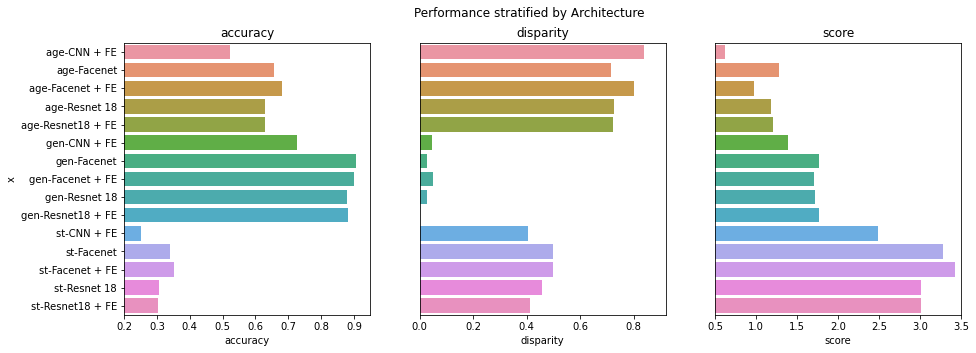

In [332]:
def bm_names(string):
    string = string.replace('../../data/models/','')
    names = {
        'baseline_cnndualencoder_model_h500_h500_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalancedsoftembed0.0_lw5-2-1_noise01_smote0.5_flprot0.7-0.1_V0.1615': 'CNN + FE',
        'smalldualencoder_dualfacenet_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedsoftembed0.0_lw5-2-1_noise01_smote0.5_flprot0.7-0.1_V0.6664': 'Facenet + FE',
        'resnetsmalldualencoder_model_h400_ed3triplet_decoder__st100_a40_g20_std2_ad2_gd2_rbalancedsoftembed0.0_lw5-2-1_noise01_smote0.5_flprot0.7-0.1_V0.491': 'Resnet18 + FE',
        'simpledualencoder_dualfacenet_h500_h500_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalancedsoftembed0.0_lw5-2-1_noise01_smote0.5_flprot0.7-0.1_V0.092': 'Facenet',
        'simpleresenetdualencoder_model_h500_h500_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalancedsoftembed0.0_lw5-2-1_noise01_smote0.5_flprot0.7-0.1_V0.5746': "Resnet 18"
    }
    return names.get(string,'?')
    
base_models = unravel_metrics(pd.read_csv(Constants.result_folder + 'model_gridsearch.csv').drop('Unnamed: 0',axis=1))
base_models['mname'] = base_models.model.apply(bm_names)
plot_metric(base_models.sort_values('score',ascending=False).groupby('mname').first().reset_index(),
            'mname',
            title = 'Architecture',
            alim = [.2,.95],
            dlim=[0,.92],
            slim=[.5,3.5]
           )
base_models.sort_values('score',ascending=False)

In [336]:
smote_df['test_score'] = smote_df.model.apply(lambda x: smote_test_scores.get(x).get('score'))
smote_df.sort_values('test_score',ascending=False)

score      loss  \
dual  softmax noise embed_weight smote                       
True  False   0.01  0.1          0.9    7.512290  6.123685   
False True    0.01  0.9          0.0    7.791536  6.034848   
True  False   0.01  0.9          0.5    7.662343  6.102026   
False True    0.01  0.0          0.9    7.485655  6.076859   
      False   0.01  0.9          0.5    7.780896  6.062746   
                    0.0          0.0    7.542976  6.065924   
      True    0.01  0.9          0.5    7.835547  6.007534   
                    0.1          0.5    7.545885  6.062739   
      False   0.01  0.9          0.0    7.581640  6.089821   
True  False   0.01  0.9          0.9    7.649905  6.099589   
False True    0.01  0.1          0.0    7.652904  6.074637   
True  True    0.01  0.1          0.5    7.588341  6.086965   
False False   0.01  0.1          0.9    7.598286  6.040111   
      True    0.01  0.1          0.9    7.571199  6.029916   
                    0.0          0.5    7.048586  6.131949   
                    0.9          0.9    7.584182  6.036255   
True  True    0.01  0.1          0.9    7.589274  6.133145   
False False   0.01  0.0          0.5    7.566871  6.070975   
                    0.1          0.0    7.597733  6.035575   
True  True    0.01  0.9          0.0    7.610636  6.042082   
False False   0.01  0.1          0.5    7.598583  6.053990   
                    0.0          0.9    7.367869  6.056554   
                    0.9          0.9    7.231303  6.037992   
True  True    0.01  0.9          0.9    6.266818  6.114607   
                    0.1          0.0    6.251948  6.119481   
      False   0.01  0.1          0.5    6.211707  6.165499   
                    0.0          0.5    6.261657  6.177577   
      True    0.01  0.9          0.5    6.320372  6.056283   
      False   0.01  0.1          0.0    6.289895  6.111638   
                    0.0          0.9    6.401409  6.130093   
      True    0.01  0.0          0.5    6.338873  6.117104   
False True    0.01  0.0          0.0    6.237326  6.086209   
True  False   0.01  0.9          0.0    6.141765  6.084509   
      True    0.01  0.0          0.9    6.154104  6.190832   
      False   0.01  0.0          0.0    6.006757  6.164270   
      True    0.01  0.0          0.0    5.766613  6.140866   

                                                                                    model  \
dual  softmax noise embed_weight smote                                                      
True  False   0.01  0.1          0.9    ../../data/models/gridsearch_simpledualencoder...   
False True    0.01  0.9          0.0    ../../data/models/gridsearch3_smalldualencoder...   
True  False   0.01  0.9          0.5    ../../data/models/gridsearch_simpledualencoder...   
False True    0.01  0.0          0.9    ../../data/models/gridsearch3_smalldualencoder...   
      False   0.01  0.9          0.5    ../../data/models/gridsearch3_smalldualencoder...   
                    0.0          0.0    ../../data/models/gridsearch3_smalldualencoder...   
      True    0.01  0.9          0.5    ../../data/models/gridsearch3_smalldualencoder...   
                    0.1          0.5    ../../data/models/gridsearch3_smalldualencoder...   
      False   0.01  0.9          0.0    ../../data/models/gridsearch3_smalldualencoder...   
True  False   0.01  0.9          0.9    ../../data/models/gridsearch_simpledualencoder...   
False True    0.01  0.1          0.0    ../../data/models/gridsearch3_smalldualencoder...   
True  True    0.01  0.1          0.5    ../../data/models/gridsearch_simpledualencoder...   
False False   0.01  0.1          0.9    ../../data/models/gridsearch3_smalldualencoder...   
      True    0.01  0.1          0.9    ../../data/models/gridsearch3_smalldualencoder...   
                    0.0          0.5    ../../data/models/gridsearch3_smalldualencoder...   
                    0.9          0.9    ../../data/models/gridsearch3_smalldualencoder...   
True  True  

In [337]:
smote_df.sort_values('score',ascending=False)

score      loss  \
dual  softmax noise embed_weight smote                       
False True    0.01  0.9          0.5    7.835547  6.007534   
                                 0.0    7.791536  6.034848   
      False   0.01  0.9          0.5    7.780896  6.062746   
True  False   0.01  0.9          0.5    7.662343  6.102026   
False True    0.01  0.1          0.0    7.652904  6.074637   
True  False   0.01  0.9          0.9    7.649905  6.099589   
      True    0.01  0.9          0.0    7.610636  6.042082   
False False   0.01  0.1          0.5    7.598583  6.053990   
                                 0.9    7.598286  6.040111   
                                 0.0    7.597733  6.035575   
True  True    0.01  0.1          0.9    7.589274  6.133145   
                                 0.5    7.588341  6.086965   
False True    0.01  0.9          0.9    7.584182  6.036255   
      False   0.01  0.9          0.0    7.581640  6.089821   
      True    0.01  0.1          0.9    7.571199  6.029916   
      False   0.01  0.0          0.5    7.566871  6.070975   
      True    0.01  0.1          0.5    7.545885  6.062739   
      False   0.01  0.0          0.0    7.542976  6.065924   
True  False   0.01  0.1          0.9    7.512290  6.123685   
False True    0.01  0.0          0.9    7.485655  6.076859   
      False   0.01  0.0          0.9    7.367869  6.056554   
                    0.9          0.9    7.231303  6.037992   
      True    0.01  0.0          0.5    7.048586  6.131949   
True  False   0.01  0.0          0.9    6.401409  6.130093   
      True    0.01  0.0          0.5    6.338873  6.117104   
                    0.9          0.5    6.320372  6.056283   
      False   0.01  0.1          0.0    6.289895  6.111638   
      True    0.01  0.9          0.9    6.266818  6.114607   
      False   0.01  0.0          0.5    6.261657  6.177577   
      True    0.01  0.1          0.0    6.251948  6.119481   
False True    0.01  0.0          0.0    6.237326  6.086209   
True  False   0.01  0.1          0.5    6.211707  6.165499   
      True    0.01  0.0          0.9    6.154104  6.190832   
      False   0.01  0.9          0.0    6.141765  6.084509   
                    0.0          0.0    6.006757  6.164270   
      True    0.01  0.0          0.0    5.766613  6.140866   

                                                                                    model  \
dual  softmax noise embed_weight smote                                                      
False True    0.01  0.9          0.5    ../../data/models/gridsearch3_smalldualencoder...   
                                 0.0    ../../data/models/gridsearch3_smalldualencoder...   
      False   0.01  0.9          0.5    ../../data/models/gridsearch3_smalldualencoder...   
True  False   0.01  0.9          0.5    ../../data/models/gridsearch_simpledualencoder...   
False True    0.01  0.1          0.0    ../../data/models/gridsearch3_smalldualencoder...   
True  False   0.01  0.9          0.9    ../../data/models/gridsearch_simpledualencoder...   
      True    0.01  0.9          0.0    ../../data/models/gridsearch_simpledualencoder...   
False False   0.01  0.1          0.5    ../../data/models/gridsearch3_smalldualencoder...   
                                 0.9    ../../data/models/gridsearch3_smalldualencoder...   
                                 0.0    ../../data/models/gridsearch3_smalldualencoder...   
True  True    0.01  0.1          0.9    ../../data/models/gridsearch_simpledualencoder...   
                                 0.5    ../../data/models/gridsearch_simpledualencoder...   
False True    0.01  0.9          0.9    ../../data/models/gridsearch3_smalldualencoder...   
      False   0.01  0.9          0.0    ../../data/models/gridsearch3_smalldualencoder...   
      True    0.01  0.1          0.9    ../../data/models/gridsearch3_smalldualencoder...   
      False   0.01  0.0          0.5    ../../data/models/gridsearch3_smalldualencoder...   
      True  

(3000, 5)
3000 30


{'submission_name': 'placeholder',
 'score': 7.024338581199865,
 'metrics': {'accuracy': {'skin_tone': 0.30133333333333334,
   'age': 0.655,
   'gender': 0.8396666666666667},
  'disparity': {'skin_tone': 0.4868421052631579,
   'age': 0.26727746595386986,
   'gender': 0.011165742581162652}}}

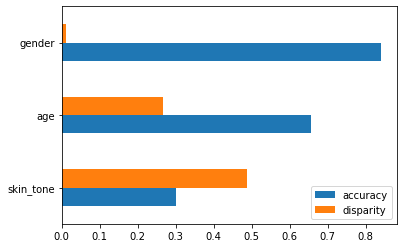

In [335]:
smote_df.sort_values('test_score',ascending=False).model.iloc[0]
BEST_MODEL= '../../data/models/gridsearch_simpledualencoder_dualfacenet_h500_h500_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalancedembed0.11_lw2-1-2_noise01_smote0.9_flprot0.7-0.1_V0.3116'
res, y, ypred = model_score(BEST_MODEL,test_labels)
pd.DataFrame(res['metrics']).plot(kind='barh')
res

{'submission_name': 'placeholder',
 'score': 4.901028197626916,
 'metrics': {'accuracy': {'skin_tone': 0.26766666666666666,
   'age': 0.5886666666666667,
   'gender': 0.7996666666666666},
  'disparity': {'skin_tone': 0.59765625,
   'age': 0.7647058823529411,
   'gender': 0.09290372075182196}}}

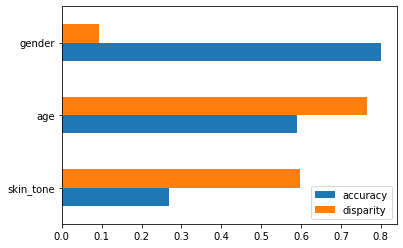

In [340]:
triplet_model_v2 = '../../data/models/gridsearch_simpledualencoder_dualfacenet_h500_h500_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalancedsoftembed9.0_lw5-2-1_noise01_smote0.9_flprot0.7-0.1_V0.3203'
res2, y2, ypred2 = model_score(triplet_model_v2,test_labels)
pd.DataFrame(res2['metrics']).plot(kind='barh')
res2

/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'skin_tone':                   0         1         2         3         4         5  \
 accuracy   0.943667  0.767667  0.754000  0.703000  0.790667  0.911667   
 f1         0.000000  0.327869  0.331522  0.347253  0.340336  0.043321   
 precision  0.000000  0.281457  0.327370  0.299621  0.327273  0.428571   
 recall     0.000000  0.392610  0.335780  0.412892  0.354486  0.022814   
 
                   6         7         8      9  differential  multiclass  
 accuracy   0.890333  0.892000  0.964667  0.985      0.282000    0.301333  
 f1         0.304440  0.313559  0.000000  0.000      0.347253    0.200830  
 precision  0.331797  0.231250  0.000000  0.000      0.428571    0.222734  
 recall     0.281250  0.486842  0.000000  0.000      0.486842    0.228667  ,
 'age':                   0         1         2         3  differential  multiclass
 accuracy   0.880000  0.701000  0.759000  0.970000      0.269000    0.655000
 f1         0.705882  0.708861  0.512475  0.575472      0.196386    0.625

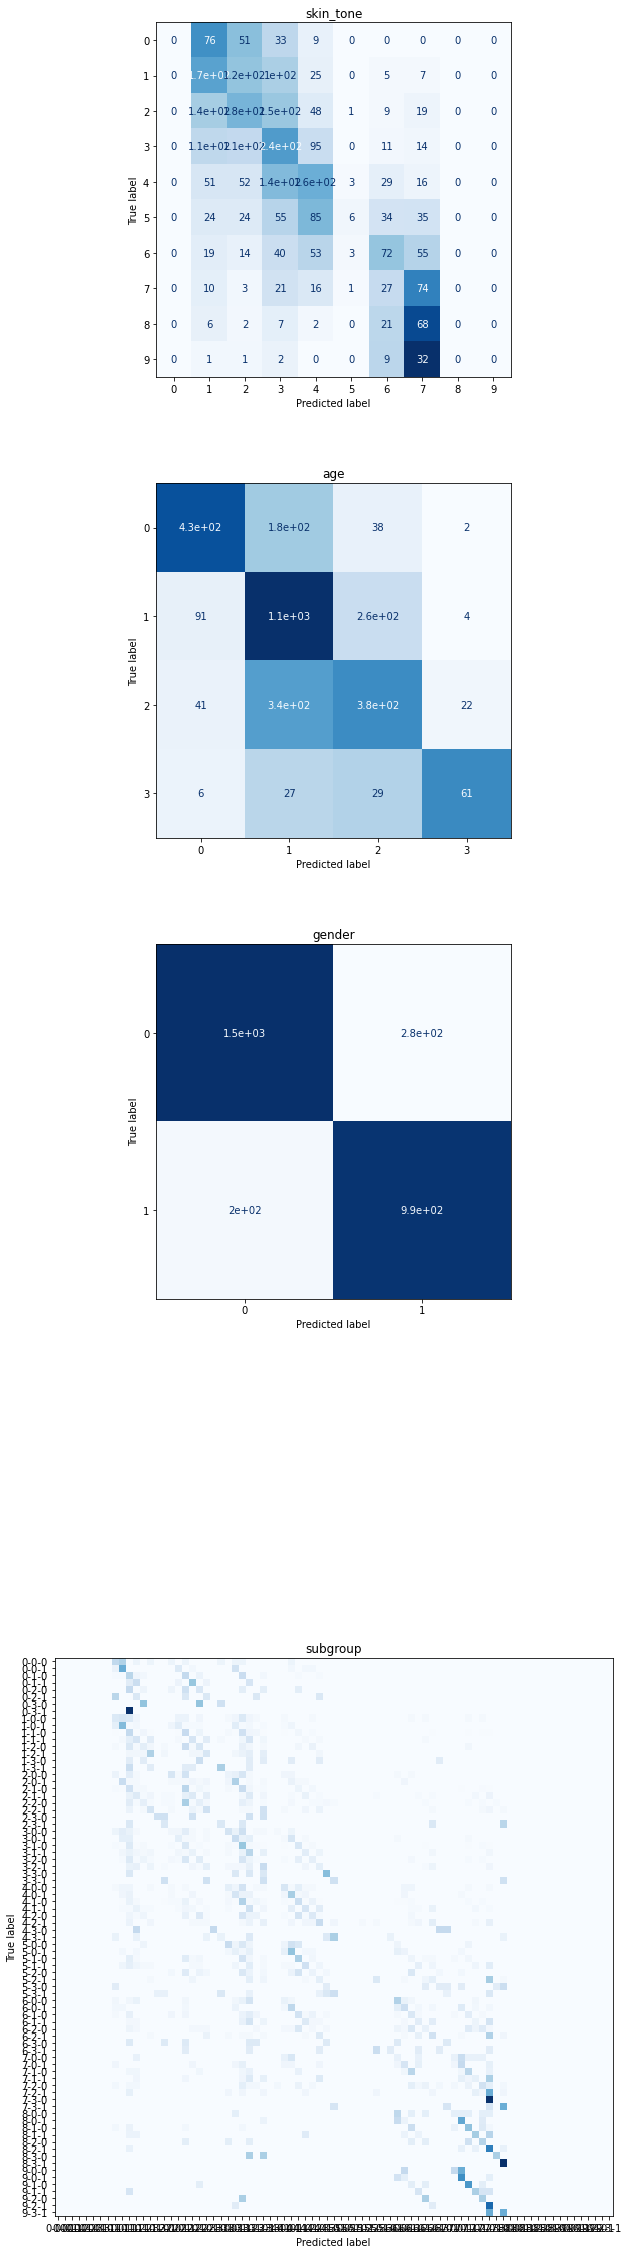

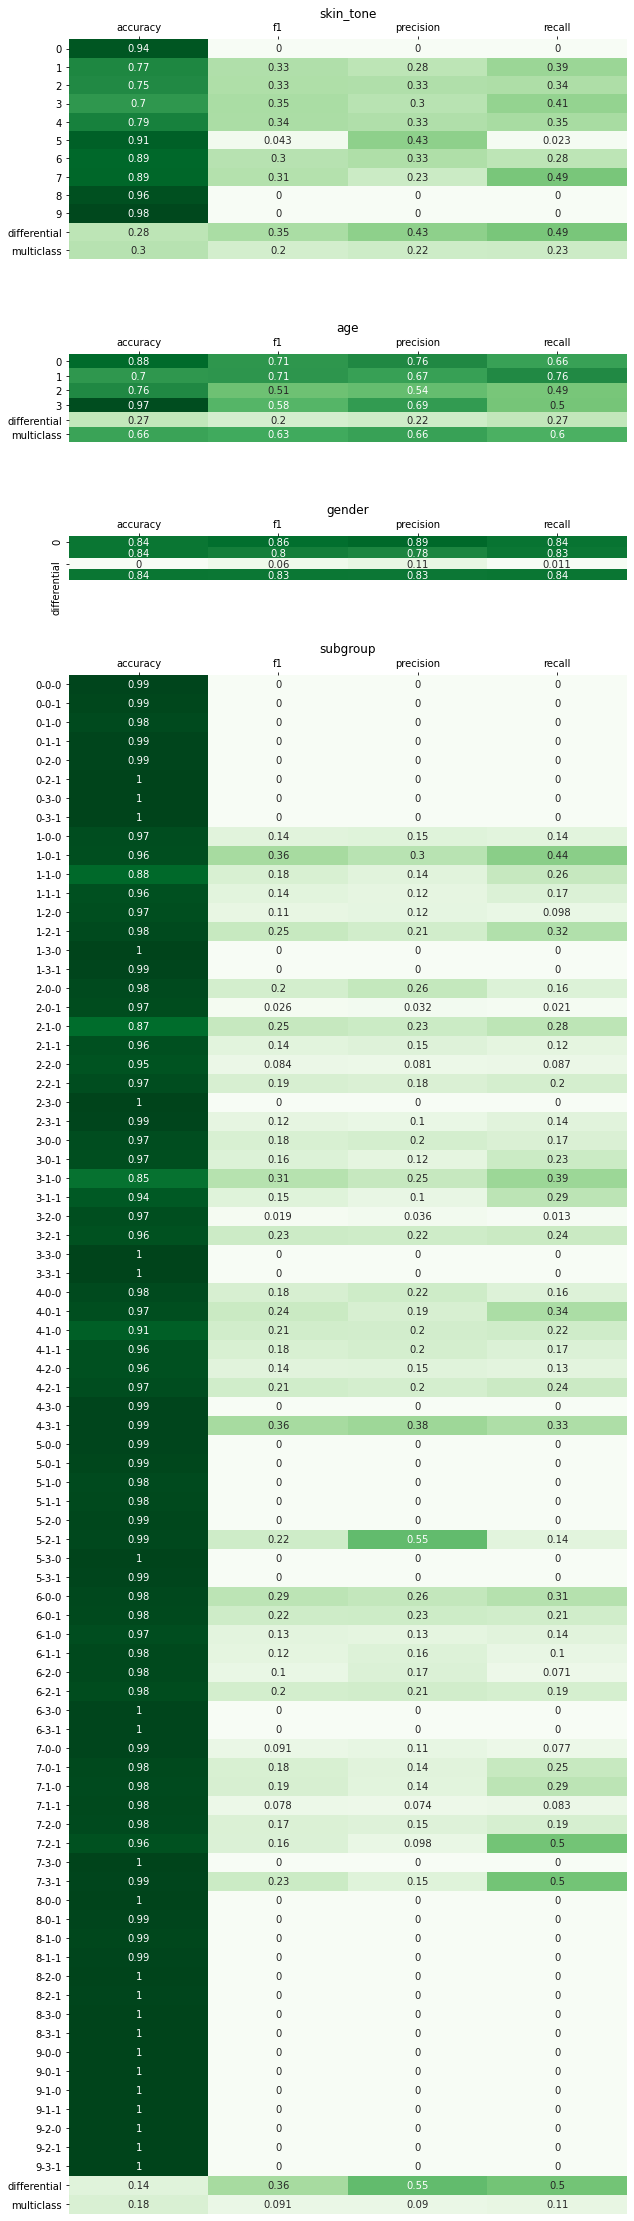

In [221]:
resultify(y,ypred)

/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'skin_tone':                   0         1         2         3         4         5  \
 accuracy   0.943667  0.825000  0.678667  0.707000  0.800667  0.912333   
 f1         0.000000  0.279835  0.310443  0.340585  0.258065  0.000000   
 precision  0.000000  0.344595  0.254396  0.299078  0.297994  0.000000   
 recall     0.000000  0.235566  0.398165  0.395470  0.227571  0.000000   
 
                   6         7         8      9  differential  multiclass  
 accuracy   0.769000  0.949333  0.964667  0.985      0.306333    0.267667  
 f1         0.306306  0.000000  0.000000  0.000      0.340585    0.149523  
 precision  0.205922  0.000000  0.000000  0.000      0.344595    0.140198  
 recall     0.597656  0.000000  0.000000  0.000      0.597656    0.185443  ,
 'age':                   0         1         2      3  differential  multiclass
 accuracy   0.807667  0.656667  0.754000  0.959      0.302333    0.588667
 f1         0.598469  0.682099  0.385000  0.000      0.682099    0.416392
 prec

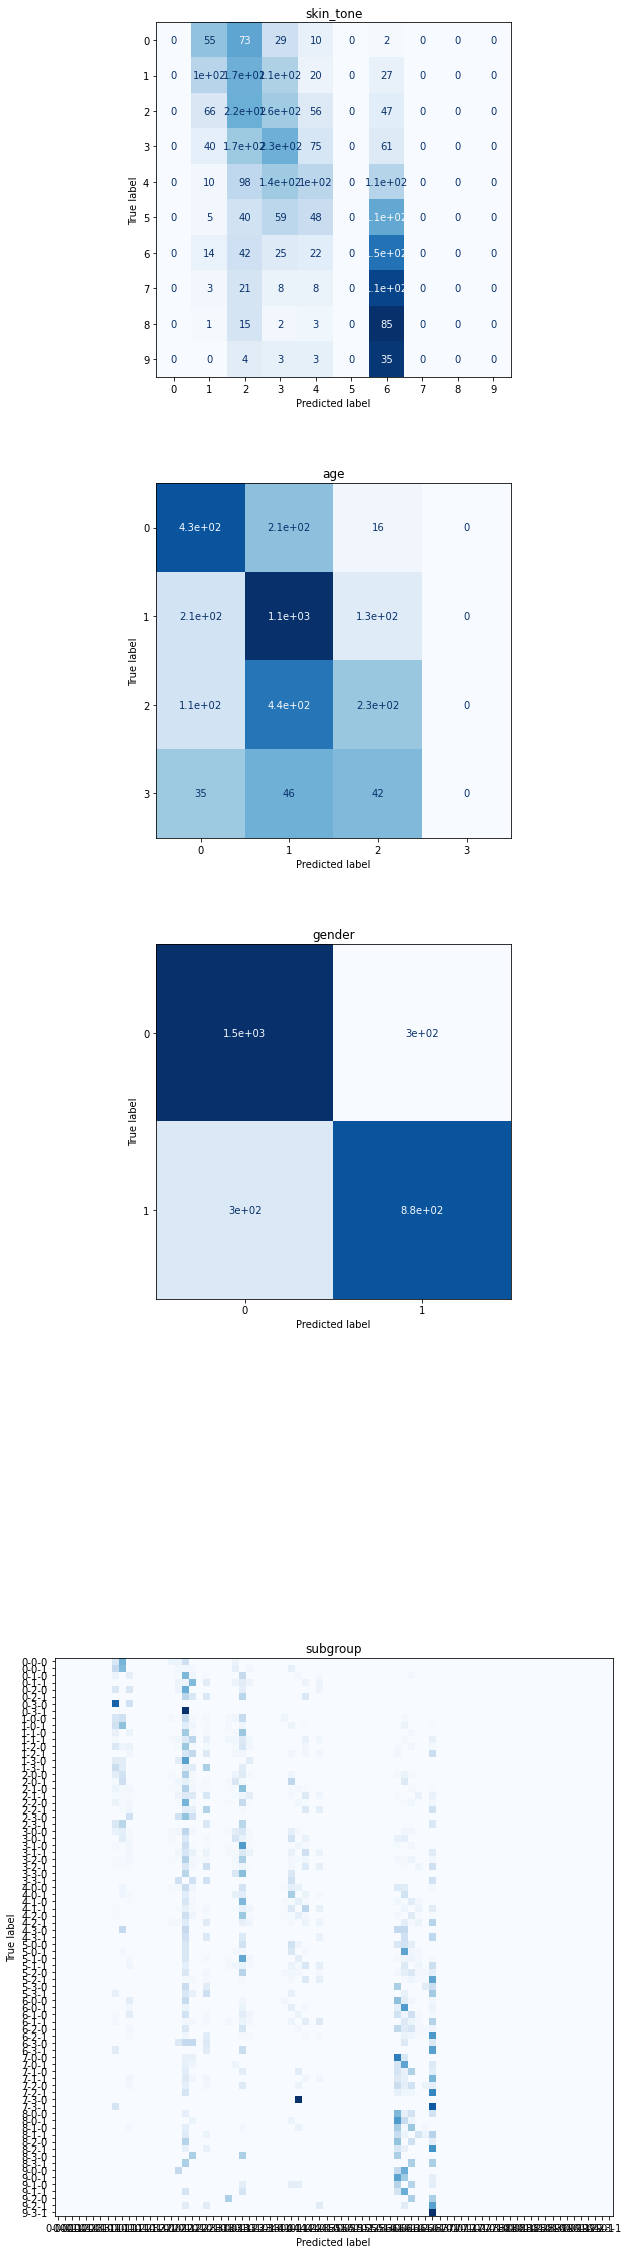

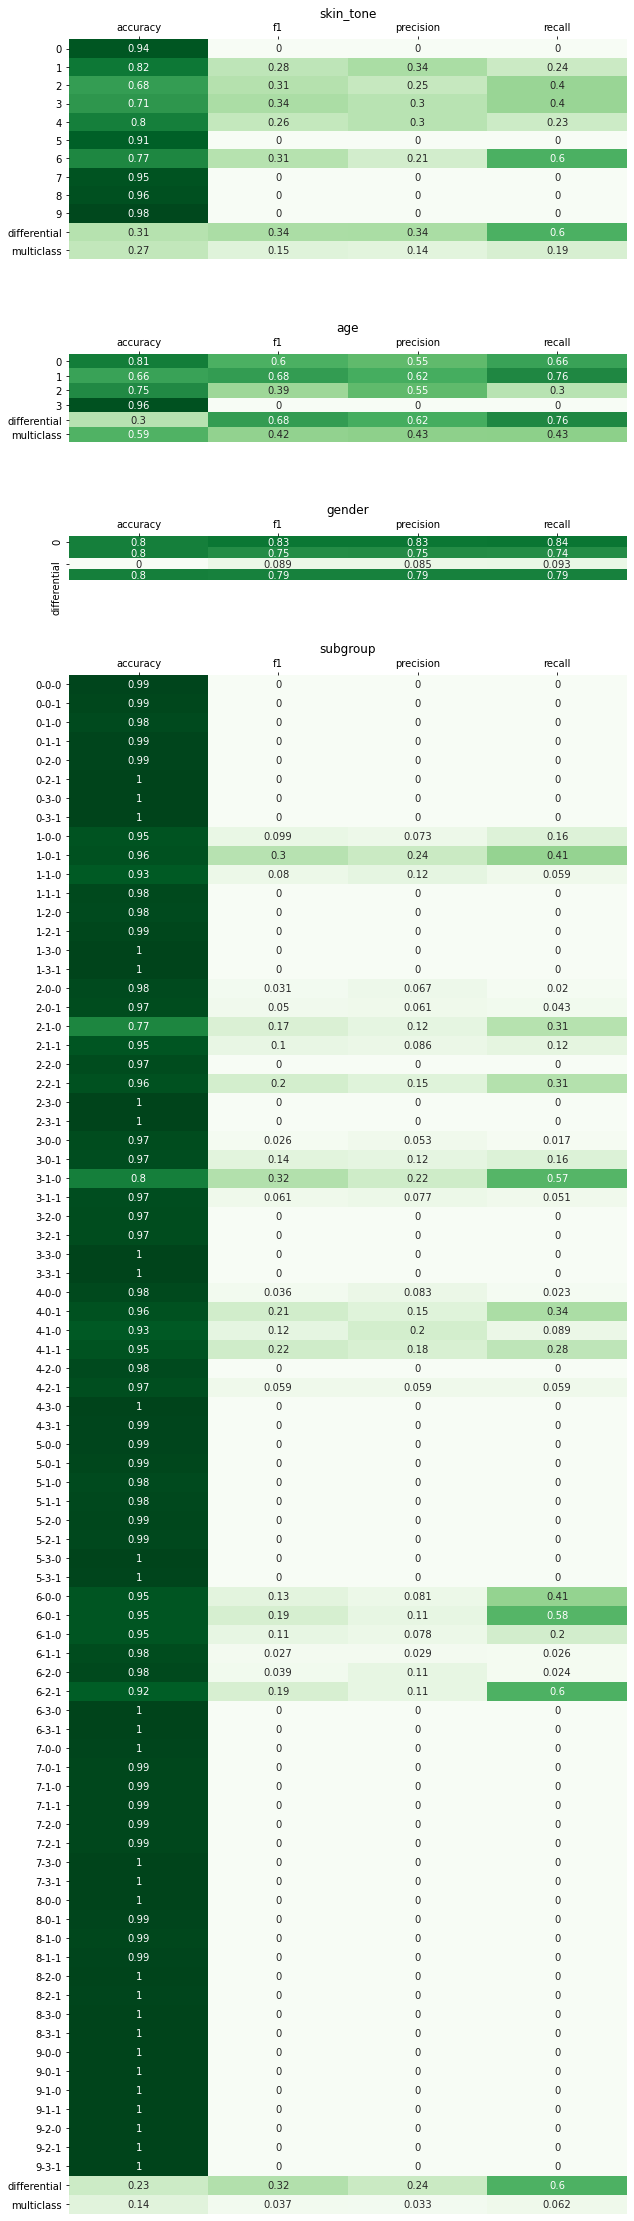

In [339]:
resultify(y2,ypred2)

In [8]:
def get_history(modelfile):
    #I messed up in logging this but it shoud always be balanced, bascially
    modelfile = modelfile.replace('_balanced','')
    hist = pd.read_csv(Constants.result_folder+'history_' + modelfile+'.csv')
    return hist

def plot_history(file,ax=None):
    history = get_history(file)
    train_loss = history.train_loss.values
    val_loss = history.val_loss.values
    x = [i for i,k in enumerate(train_loss)]
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(x,train_loss,c='b')
    ax.plot(x,val_loss,c='r')
    ax.set_title('Training history')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    return ax

plot_history(file)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/results/history_dualencoder_resnet_stanchor_h400_ed5triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced.csv'

In [ ]:
#code to export results into a file that can be used for triplet loss?
import itertools
def subgroup_neighbors(y,ypred,agg_func=np.nansum,stringify_index=False):
    classes = [sorted(np.unique(yy)) for yy in y]
    labels = Constants.labels[:]
    class_combos = list(itertools.product(*classes))
    ooc = {}
    ic = {}
    for combo in class_combos:
        probs = [yp[:,c] for c,yp in zip(combo,ypred)]
        total_prob = agg_func(probs,axis=0)
        true_class = np.all(np.stack([yy == c for yy,c in zip(y,combo)]),axis=0)
        ooc_probs = total_prob*(~true_class).astype(int)
        ic_probs = total_prob*true_class.astype(int)
        if stringify_index:
            key ='-'.join([str(c) for c in combo])
        else:
            key = combo
        ooc[key] = ooc_probs
        ic[key] = ic_probs
    return ooc,ic

def add_triplet_values(model,label_df,y=None,ypred=None,use_histogram=False,**kwargs):
    if y is None or ypred is None:
        y,ypred = eval_labels(model,label_df,use_histogram=use_histogram,filter_nonfaces=False)
    ooc, ic = subgroup_neighbors(y,ypred,stringify_index=True,**kwargs)
    newdf = []
    pos = 0
    for i,row in label_df.copy().iterrows():
        entry = row.to_dict()
        for k,v in ooc.items():
            anchor = ic.get(k)
            entry[k + '_anchor'] = anchor[pos]
            entry[k + '_bias'] = v[pos]
        pos += 1
        newdf.append(entry)
    return pd.DataFrame(newdf)
   
HISTOGRAM = False
SURNAME = 'balanceddual'
print('train_data_augmented_' + SURNAME + '.csv')
print('validation_data_augmented_' + SURNAME + '.csv')

In [ ]:
train_y, train_ypred = eval_labels(model,train_labels,use_histogram=HISTOGRAM,filter_nonfaces=False)
temp = add_triplet_values(model,train_labels,y=train_y,ypred=train_ypred, use_histogram=HISTOGRAM)
temp.to_csv('train_data_augmented_' + SURNAME + '.csv')
print(temp.head())

In [ ]:
val_y, val_ypred = eval_labels(model,val_labels,use_histogram=HISTOGRAM,filter_nonfaces=False)
temp_v = add_triplet_values(model,val_labels,y=val_y,ypred=val_ypred,use_histogram=HISTOGRAM)
temp_v.to_csv('validation_data_augmented_' + SURNAME + '.csv')
temp_v